## 1. Общий датасет гистограмм и моделей лежит на гугл диске:
https://drive.google.com/drive/folders/1CjqyVZ6PqPoYqHlTBYgTzQZAodvDYBm5

## 2. Кластеризация полученных гистограмм

In [1]:
# Download data

!gdown https://drive.google.com/uc?id=1_GItRPcHjVn52HEIcuhWLi7FZicUhPhO
!gdown https://drive.google.com/uc?id=1MqgoMBZVEy4T9qKWWToHh7rNwqrrnHGK
!gdown https://drive.google.com/uc?id=1JnnbtKOj0H_8wQu1TnhnrWXXKPr_NIB7

Downloading...
From: https://drive.google.com/uc?id=1_GItRPcHjVn52HEIcuhWLi7FZicUhPhO
To: /content/models.zip
100% 97.2M/97.2M [00:01<00:00, 82.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MqgoMBZVEy4T9qKWWToHh7rNwqrrnHGK
To: /content/labels.csv
100% 443k/443k [00:00<00:00, 61.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JnnbtKOj0H_8wQu1TnhnrWXXKPr_NIB7
To: /content/histograms_28_10_21_11_06.zip
100% 29.2M/29.2M [00:00<00:00, 56.7MB/s]


In [2]:
!unzip -q histograms_28_10_21_11_06.zip
!unzip -q models.zip

In [3]:
import os
paths_hist = sorted(os.listdir('histograms/'))
paths_models = sorted(os.listdir('models/'))

### Reading data

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import json

In [5]:
root = 'histograms/'
num_hists = len(os.listdir(root))
hists = []

for i in range(num_hists):
  with open(os.path.join(root, paths_hist[i])) as f:
    data = json.load(f)
    hists.append(data['histogram_data'])

In [6]:
print('Total hists num:', len(data['histogram_data']))
print('Num bins in each type of hist:',
      [el['intervals'] for el in data['histogram_data'] if el['type'] == 'model_bounding_sphere_strict_outer'])

Total hists num: 40
Num bins in each type of hist: [8, 16, 32, 64, 128]


In [7]:
# Process label data

labels = pd.read_csv('labels.csv')
labels['type'] = labels['type'].str.replace(r'\.\d*', '')
unique_labels = np.unique(labels["type"].values)
print(f'Unique labels: {unique_labels}')

Unique labels: ['Cone' 'Cube' 'Cylinder' 'Sphere' 'Torus']


In [8]:
labels_y = []

for hist_name in paths_hist:
    label = labels[labels['model'] == hist_name.replace('.json', '')]['type']
    labels_y.append(label)

labels_y = np.array(labels_y)
print(f'y shape: {labels_y.shape}')

y shape: (2137, 1)


### Visualization

In [9]:
!pip install -qU scikit-learn

     |████████████████████████████████| 23.2 MB 1.6 MB/s 


In [10]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE
import seaborn as sns
from scipy.stats import mode
from sklearn.metrics import classification_report
plt.style.use('seaborn')

In [11]:
# Visualization function for TSNE embeddings

def visualize(X, y, title=None, size=8, show_y_true=False, y_true=None):
    unique_labels = np.unique(y)
    palette = np.array(sns.color_palette("hls", len(unique_labels)))
    if show_y_true:
        fig, ax = plt.subplots(1, 2, figsize=(2*size, size))
        unique_labels_true = np.unique(y_true)
        palette = np.array(sns.color_palette("hls", len(unique_labels_true)))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(size, size))
        ax = [ax]

    for i, label in enumerate(unique_labels):
        mask = (y == label).ravel()
        ax[0].scatter(X[mask,0], X[mask,1], color=palette[i], s=14, label=label)
    
    if show_y_true:
        for i, label in enumerate(unique_labels_true):
            mask = (y_true == label).ravel()
            ax[1].scatter(X[mask,0], X[mask,1], color=palette[i], s=14, label=label)
        ax[1].legend(facecolor="white", prop={'size': 12}, frameon=True)
    
    if title is not None:
        if isinstance(title, list):
            ax[0].set_title(title[0], fontsize=16)
            ax[1].set_title(title[1], fontsize=16)
        else:
            ax[0].set_title(title, fontsize=16)

    ax[0].legend(facecolor="white", prop={'size': 12}, frameon=True)
    plt.show()

Посмотрим на разделение гистограмм на кластеры в зависимости от количества бинов: 

X shape: (2137, 64)


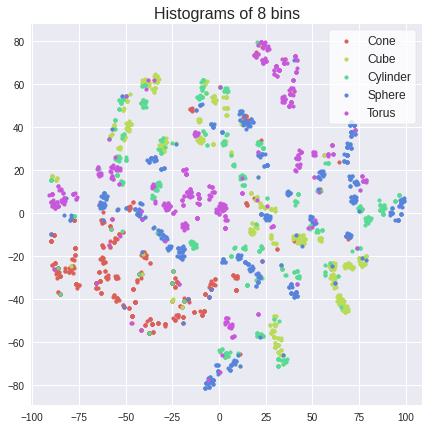

X shape: (2137, 128)


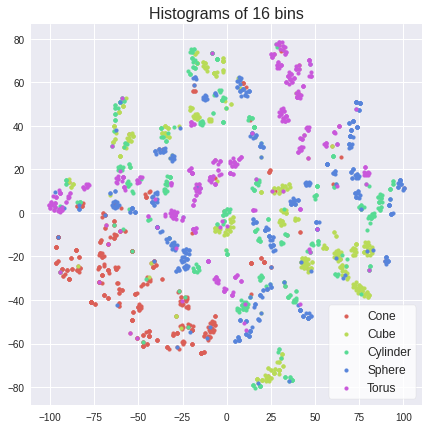

X shape: (2137, 256)


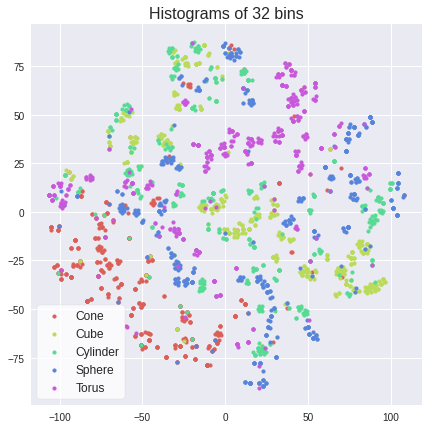

X shape: (2137, 512)


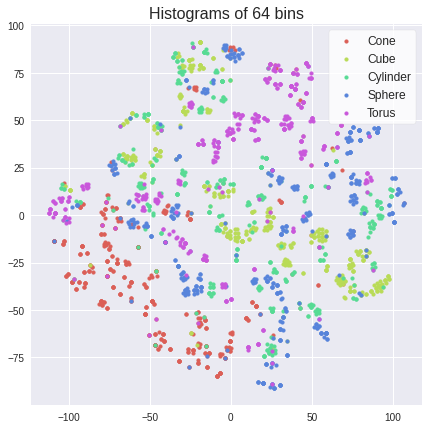

X shape: (2137, 1024)


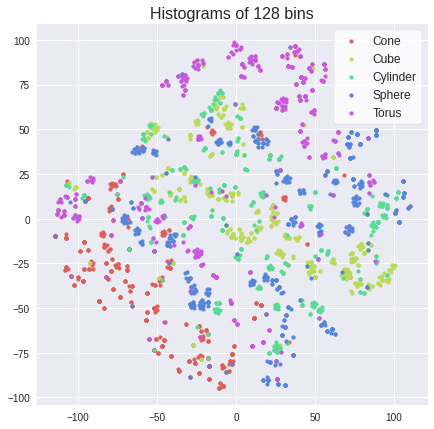

In [12]:
for num_bins in [8, 16, 32, 64, 128]:
    X = []

    for i in range(num_hists):
        concat_hist = []
        for h in hists[i]:
            if h['intervals'] == num_bins:
                concat_hist.extend(h['data'])
        X.append(np.array(concat_hist))

    X = np.array(X)
    print(f'X shape: {X.shape}')

    # apply TSNE to visualize 
    tsne = TSNE(n_components=2, learning_rate='auto', init='random', random_state=21)
    X_embedded = tsne.fit_transform(X.astype(np.float32))

    visualize(X_embedded, labels_y, title=f'Histograms of {num_bins} bins', size=7)

Из графиков видно, что некоторые кластеры различаются, но нет оптимального числа бинов, где было бы идеальное разделение. Поэтому будем пробовать кластеризацию для разных наборов дескрипторов. Ниже представлены варианты кластеризаций с лучшими значениями финальных метрик для `KMeans`, `Agglomerative` и `DBSCAN`

### Clustering

In [13]:
# define labels for y_pred clusters as mode of points in cluster 

def get_labels(y_pred, y_true):
    new_y_pred = y_pred.copy().astype(str)
    labels = np.unique(y_pred)
    for label in labels:
        mask = (y_pred == label)
        new_label = mode(y_true[mask]).mode[0,0]
        new_y_pred[mask] = new_label
    return new_y_pred

#### K-means clustering



In [14]:
# 16 bins descriptors

# get hists only of 16 bins
X = []
num_bins = 16

for i in range(num_hists):
    concat_hist = []
    for h in hists[i]:
        if h['intervals'] == num_bins:
            concat_hist.extend(h['data'])
    X.append(np.array(concat_hist))

X = np.array(X)
print(f'X shape: {X.shape}')

X shape: (2137, 128)


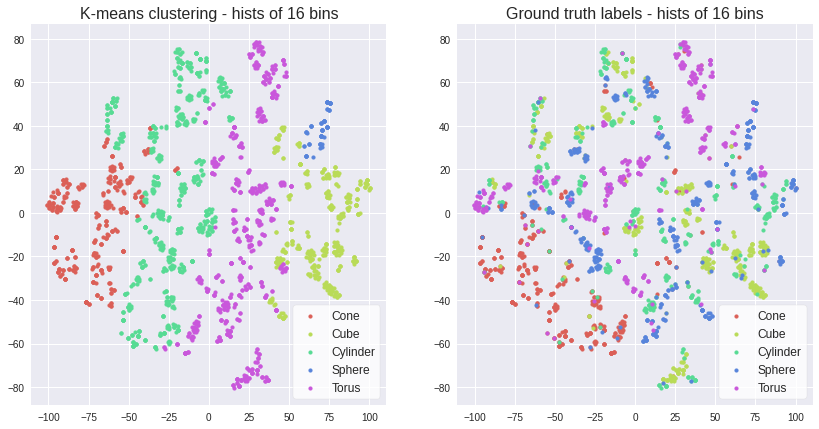

              precision    recall  f1-score   support

        Cone       0.49      0.45      0.47       424
        Cube       0.31      0.29      0.30       394
    Cylinder       0.22      0.36      0.27       414
      Sphere       0.74      0.11      0.19       477
       Torus       0.28      0.41      0.33       428

    accuracy                           0.32      2137
   macro avg       0.41      0.32      0.31      2137
weighted avg       0.42      0.32      0.31      2137



In [15]:
# fit kmeans clustering
kmeans = KMeans(n_clusters=5)
y_pred = kmeans.fit_predict(X)

# apply TSNE to visualize 
tsne = TSNE(n_components=2, learning_rate='auto', init='random', random_state=21)
X_embedded = tsne.fit_transform(X.astype(np.float32))
y_pred_labels = get_labels(y_pred, labels_y)

#  visualization
visualize(X_embedded, 
          y_pred_labels, 
          title=[f'K-means clustering - hists of {num_bins} bins', 
                 f'Ground truth labels - hists of {num_bins} bins'], 
          size=7, 
          show_y_true=True, 
          y_true=labels_y)

# calculate metrics
print(classification_report(labels_y, y_pred_labels, zero_division=0))

#### Agglomerative clustering

In [16]:
# 64 bins

# get hists only of 64 bins
X = []
num_bins = 64

for i in range(num_hists):
    concat_hist = []
    for h in hists[i]:
        if h['intervals'] == num_bins:
            concat_hist.extend(h['data'])
    X.append(np.array(concat_hist))

X = np.array(X)
print(f'X shape: {X.shape}')

X shape: (2137, 512)


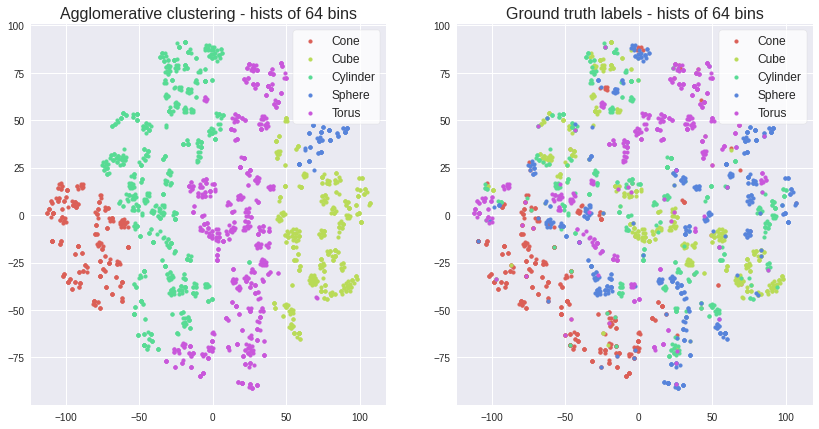

              precision    recall  f1-score   support

        Cone       0.66      0.43      0.52       424
        Cube       0.31      0.31      0.31       394
    Cylinder       0.22      0.37      0.28       414
      Sphere       0.76      0.13      0.22       477
       Torus       0.25      0.40      0.31       428

    accuracy                           0.32      2137
   macro avg       0.44      0.33      0.33      2137
weighted avg       0.45      0.32      0.32      2137



In [17]:
# fit agglomerative clustering
agg = AgglomerativeClustering(n_clusters=5)
y_pred = agg.fit_predict(X)

# apply TSNE to visualize 
tsne = TSNE(n_components=2, learning_rate='auto', init='random', random_state=21)
X_embedded = tsne.fit_transform(X.astype(np.float32))
y_pred_labels = get_labels(y_pred, labels_y)

#  visualization
visualize(X_embedded, 
          y_pred_labels, 
          title=[f'Agglomerative clustering - hists of {num_bins} bins', 
                 f'Ground truth labels - hists of {num_bins} bins'], 
          size=7, 
          show_y_true=True, 
          y_true=labels_y)

# calculate metrics
print(classification_report(labels_y, y_pred_labels, zero_division=0))

#### DBSCAN

In [18]:
# 64 bins

# get hists only of 64 bins
X = []
num_bins = 64

for i in range(num_hists):
    concat_hist = []
    for h in hists[i]:
        if h['intervals'] == num_bins:
            concat_hist.extend(h['data'])
    X.append(np.array(concat_hist))

X = np.array(X)
print(f'X shape: {X.shape}')

X shape: (2137, 512)


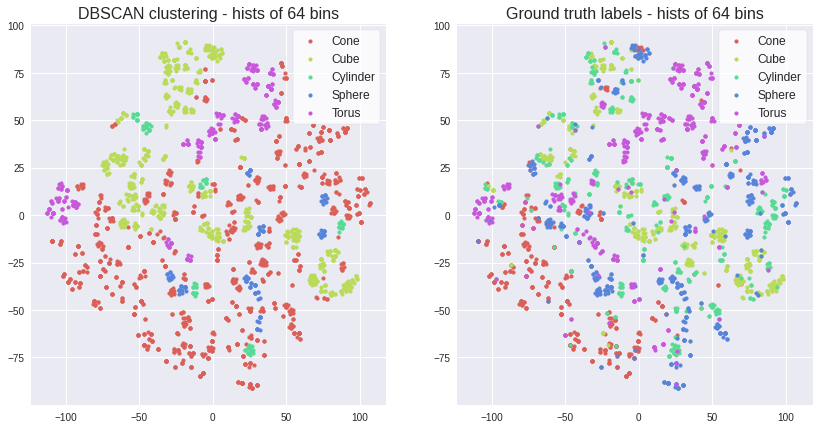

              precision    recall  f1-score   support

        Cone       0.34      0.90      0.50       424
        Cube       0.52      0.75      0.62       394
    Cylinder       0.82      0.16      0.27       414
      Sphere       0.94      0.22      0.35       477
       Torus       0.81      0.51      0.63       428

    accuracy                           0.50      2137
   macro avg       0.69      0.51      0.47      2137
weighted avg       0.70      0.50      0.47      2137



In [19]:
# fit DBSCAN clustering
dbscan = DBSCAN(eps=0.05, min_samples=10)
y_pred = dbscan.fit_predict(X)

# apply TSNE to visualize 
tsne = TSNE(n_components=2, learning_rate='auto', init='random', random_state=21)
X_embedded = tsne.fit_transform(X.astype(np.float32))
y_pred_labels = get_labels(y_pred, labels_y)

#  visualization
visualize(X_embedded, 
          y_pred_labels, 
          title=[f'DBSCAN clustering - hists of {num_bins} bins', 
                 f'Ground truth labels - hists of {num_bins} bins'], 
          size=7, 
          show_y_true=True, 
          y_true=labels_y)

# calculate metrics
print(classification_report(labels_y, y_pred_labels, zero_division=0))

- Лучшим по метрикам `precision` и `recall` стал алгоритм `DBSCAN`
- Во всех алгоритмах хуже всего кластеризуются классы `sphere` и `cylinder`
- Лучше всего на основе гистограмм кластеризуется классы `cube` и `torus`